In [1]:
%pylab inline
figsize(8, 6)

Populating the interactive namespace from numpy and matplotlib


##Import

In [2]:
import pandas
import numexpr
import numpy
from rep_ef.estimators import MatrixNetSkyGridClassifier
from rep.metaml import FoldingClassifier
from rep.data import LabeledDataStorage
from rep.report import ClassificationReport
from rep.report.metrics import RocAuc

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
from utils import get_N_B_events, get_events_number, get_events_statistics

# Reading tagging data

## track data

In [4]:
data_track_nan = pandas.read_csv('datasets/Tracks.csv', sep='\t')

In [5]:
data_track_nan.head()

,run,event,Bmass,i,mult,partP,partPt,ptB,IPs,IP,...,proj,ID,veloch,signB,signTrack,Dist_phi,N_sig_sw,mu_cut,e_cut,K_cut
0,115839,204997902,5.309576,0,13,3.67156,0.300418,4.004197,0.816143,0.056365,...,1.058442,-211,0.911645,1,-1,0.114615,0.59521,0,0,0
1,115839,204997902,5.309576,1,13,8.33952,1.103876,4.004197,1.375382,0.033095,...,3.121358,-211,0.796731,1,-1,0.051334,0.59521,0,0,0
2,115839,204997902,5.309576,2,13,8.37654,1.182519,4.004197,4.338812,0.077636,...,10.585135,-211,0.946629,1,-1,1.856516,0.59521,0,0,0
3,115839,204997902,5.309576,3,13,25.72961,0.905010,4.004197,2.287509,0.086603,...,7.485243,211,1.058989,1,1,0.577419,0.59521,0,0,0
4,115839,204997902,5.309576,4,13,3.70597,0.516123,4.004197,0.562424,0.015694,...,5.617354,211,1.042135,1,1,1.314513,0.59521,0,0,0


In [6]:
event_id_column = 'event_id'
data_track_nan[event_id_column] = data_track_nan.run.apply(str) + '_' + data_track_nan.event.apply(str)

In [7]:
get_events_statistics(data_track_nan)

{'Events': 1005757, 'tracks': 27156193}

In [8]:
get_N_B_events()

742867.7142562866

## Remove rows with NAN from data

In [9]:
data_track = data_track_nan.dropna()
len(data_track_nan), len(data_track), get_events_statistics(data_track)

(27156193, 27156190, {'Events': 1005757, 'tracks': 27156190})

### Add diff_pt and cos(diff_phi)

In [10]:
# add different between max pt in event and pt for each track
def add_diff_pt(data):
    max_pt = group_max(data[event_id_column].values.astype(str), data.partPt.values)
    data['diff_pt'] = max_pt - data['partPt'].values

# max is computing max over tracks in the same event for saome data
def group_max(groups, data):
    # computing unique integer id for each group
    assert len(groups) == len(data)
    _, event_id = numpy.unique(groups, return_inverse=True)
    max_over_event = numpy.zeros(max(event_id) + 1) - numpy.inf
    numpy.maximum.at(max_over_event, event_id, data)
    return max_over_event[event_id]

In [11]:
# add diff pt
add_diff_pt(data_track)
# add cos(diff_phi)
data_track['cos_diff_phi'] = numpy.cos(data_track.diff_phi.values)

### Add max, sum among PIDs

In [12]:
from itertools import combinations
PIDs = {'k': data_track.PIDNNk.values,
        'e': data_track.PIDNNe.values,
        'mu': data_track.PIDNNm.values,
       }
for (pid_name1, pid_values1), (pid_name2, pid_values2) in combinations(PIDs.items(), 2):
    data_track['max_PID_{}_{}'.format(pid_name1, pid_name2)] = numpy.maximum(pid_values1, pid_values2)
    data_track['sum_PID_{}_{}'.format(pid_name1, pid_name2)] = pid_values1 + pid_values2

## define `label` = `signB` * `signTrack`

* if > 0 (same sign) - label **1**
* if < 0 (different sign) - label **0**

In [13]:
data_track['label'] = (data_track.signB.values * data_track.signTrack.values > 0) * 1

### Filter out protons and pions, apply ghost prob cut

In [14]:
threshold_mistag = 0.6
initial_cut = '(PIDNNp < {tr}) & (PIDNNpi < {tr}) & (ghostProb < 0.4)'.format(tr=threshold_mistag)
data_track = data_track.query(initial_cut)

### Leave muons, kaons, electrons

In [15]:
threshold_kaon = 0.7 
threshold_muon = 0.4
threshold_electron = 0.6
cut_pid = """
            ((PIDNNk > {trk}) 
                | (PIDNNm > {trm}) 
                | (PIDNNe > {tre})) """.format(trk=threshold_kaon, trm=threshold_muon,
                                               tre=threshold_electron).replace("\n", "")
    
data_track = data_track.query(cut_pid)

In [16]:
get_events_statistics(data_track)

{'Events': 657874, 'tracks': 1191986}

## vertex data

In [17]:
import root_numpy
data_vertex = pandas.DataFrame(root_numpy.root2array('datasets/1016_vtx.root'))

data_vertex[event_id_column] = data_vertex.runNum.apply(str) + '_' + (data_vertex.evtNum.apply(int)).apply(str)
# reconstructing sign of B
data_vertex['signB'] = data_vertex.tagAnswer * (2 * data_vertex.iscorrect - 1)
# assure sign is +1 or -1
data_vertex['signVtx'] = (data_vertex.signVtx.values > 0) * 2 - 1
data_vertex['label'] = (data_vertex.signVtx.values * data_vertex.signB.values > 0) * 1

## Calculating tagging efficiency ($\epsilon_{tag}$)

$$N (\text{passed selection}) = \sum_{\text{passed selection}} sw_i$$

$$N (\text{all events}) = \sum_{\text{all events}} sw_i,$$

where $sw_i$ - sPLot weight

$$\epsilon_{tag} = \frac{N (\text{passed selection})} {N (\text{all events})}$$

$$\Delta\epsilon_{tag} = \frac{\sqrt{N (\text{passed selection})}} {N (\text{all events})}$$

## Choose most probable B-events

In [18]:
sweight_threshold = 1.
data_track_sw_passed = data_track[data_track.N_sig_sw > sweight_threshold]
data_track_sw_not_passed = data_track[data_track.N_sig_sw <= sweight_threshold]

data_vertex_sw_passed = data_vertex[data_vertex.N_sig_sw > sweight_threshold]
data_vertex_sw_not_passed = data_vertex[data_vertex.N_sig_sw <= sweight_threshold]
get_events_statistics(data_track_sw_passed), get_events_statistics(data_vertex_sw_passed)

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


({'Events': 409381, 'tracks': 743076}, {'Events': 247173, 'tracks': 247173})

In [19]:
data_track_sw_passed_lds = LabeledDataStorage(data_track_sw_passed, data_track_sw_passed.label,
                                              data_track_sw_passed.N_sig_sw.values)
data_vertex_sw_passed_lds = LabeledDataStorage(data_vertex_sw_passed, data_vertex_sw_passed.label,
                                               data_vertex_sw_passed.N_sig_sw.values)

# Main idea: 
## find tracks/vertices, which can help reconstruct the sign of B if you know track sign.

`label` = `signB` * `signTrack`
* the highest output means that this is same sign B as track/vertex
* the lowest output means that this is opposite sign B as track/vertex

## Define features

In [20]:
features_track = list(set(data_track.columns) - {'run', 'event', 'i', 'signB', 'signTrack', 'N_sig_sw', 
                                                 'Bmass', 'mult', 
                                                 'PIDNNp', 'PIDNNpi', 'label', 'thetaMin',
                                                 'Dist_phi', event_id_column, 
                                                 'mu_cut', 'e_cut', 'K_cut'})
features_track

['cos_diff_phi',
 'diff_pt',
 'partPt',
 'partP',
 'nnkrec',
 'diff_eta',
 'EOverP',
 'ptB',
 'sum_PID_mu_k',
 'proj',
 'PIDNNe',
 'sum_PID_k_e',
 'PIDNNk',
 'sum_PID_mu_e',
 'PIDNNm',
 'phi',
 'IP',
 'IPerr',
 'IPs',
 'ID',
 'veloch',
 'max_PID_k_e',
 'diff_phi',
 'ghostProb',
 'IPPU',
 'eta',
 'max_PID_mu_e',
 'max_PID_mu_k',
 'partlcs']

In [21]:
features_vertex =  ['mult', 'nnkrec', 'ptB', 'vflag', 'ipsmean', 'ptmean', 'vcharge', 
                     'svm', 'svp', 'BDphiDir', 'svtau', 'docamax']

----

# Training to distinguish same sign vs opposite sign

In [22]:
from rep_ef.estimators import MatrixNetSkyGridClassifier
from hep_ml.decisiontrain import DecisionTrainClassifier
from hep_ml.losses import LogLossFunction

### DT, MN base

In [23]:
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

tt_base = DecisionTrainClassifier(learning_rate=0.02, n_estimators=1500, depth=6, pretransform_needed=True, 
                                  max_features=15, loss=LogLossFunction(regularization=100))
mn_base = MatrixNetSkyGridClassifier(connection='skygrid', user_name='antares',
                                     iterations=1000, regularization=0.02, sync=False)

In [24]:
from utils import prepare_B_data_for_given_part, calibrate_probs, calculate_auc_with_and_without_untag_events

In [25]:
def tagging(base_estimator_track, base_estimator_vertex,
            track_logistic=False, vertex_logistic=False, random_state=None):
    # track training
    folding_track = FoldingClassifier(base_estimator_track, n_folds=2, 
                                      random_state=random_state, ipc_profile='ssh-ipy',
                                      features=features_track)
    folding_track.fit_lds(data_track_sw_passed_lds)

    # compute B data from track data
    Bdata_tracks = prepare_B_data_for_given_part(folding_track, 
                                                [data_track_sw_passed, data_track_sw_not_passed], 
                                                 logistic=track_logistic, random_state=random_state)

    # vertex training 
    folding_vertex = FoldingClassifier(base_estimator_vertex, n_folds=2, random_state=random_state, 
                                       features=features_vertex)
    folding_vertex.fit_lds(data_vertex_sw_passed_lds)
    
    Bdata_vertex = prepare_B_data_for_given_part(folding_vertex, 
                                                  [data_vertex_sw_passed, data_vertex_sw_not_passed], 
                                                  logistic=vertex_logistic,
                                                  sign_part_column='signVtx', part_name='vertex',
                                                 random_state=random_state)
    
    # Combine track and vertex
    Bdata = pandas.merge(Bdata_tracks, Bdata_vertex, how='outer', on=['event_id', 'Bsign'])
    
    Bdata['Bweight'] = Bdata['Bweight_x'].copy()
    Bdata.ix[numpy.isnan(Bdata['Bweight'].values), 'Bweight'] = Bdata.ix[numpy.isnan(Bdata['Bweight'].values), 'Bweight_y']
    Bdata = Bdata.drop(['Bweight_x', 'Bweight_y'], axis=1)

    # for Nan put 1 as non influence factor
    Bdata.ix[numpy.isnan(Bdata.track_relation_prob.values), 'track_relation_prob'] = 1.
    Bdata.ix[numpy.isnan(Bdata.vertex_relation_prob.values), 'vertex_relation_prob'] = 1.
    
    relation_prob = Bdata['track_relation_prob'].values * Bdata['vertex_relation_prob'].values
    Bprob = relation_prob / (1 + relation_prob)
    Bweight = Bdata.Bweight.values
    Bsign = Bdata.Bsign.values
    
    Bprob[~numpy.isfinite(Bprob)] = 0.5
    Bprob_calibrated = calibrate_probs(Bsign, Bweight, Bprob, random_state=random_state)
    
    figure(figsize=(15, 5))

    subplot(1,2,1)
    hist(Bprob[Bsign == 1], bins=60, alpha=0.2, normed=True, label='$B^+$')
    hist(Bprob[Bsign == -1], bins=60, alpha=0.2, normed=True, label='$B^-$')
    legend(), title('B probs')

    subplot(1,2,2)
    hist(Bprob_calibrated[Bsign == 1], bins=60, alpha=0.2, normed=True, range=(0, 1), label='$B^+$')
    hist(Bprob_calibrated[Bsign == -1], bins=60, alpha=0.2, normed=True, range=(0, 1), label='$B^-$')
    legend(), title('B probs calibrated')
    
    auc, auc_full = calculate_auc_with_and_without_untag_events(Bsign, Bprob_calibrated, Bweight)
    print 'AUC for tagged:', auc, 'AUC with untag:', auc_full
    
    N_B_passed = Bweight.sum()
    tagging_efficiency = N_B_passed / get_N_B_events()
    tagging_efficiency_delta = numpy.sqrt(N_B_passed) / get_N_B_events()

    D2 = numpy.average( (2*(Bprob_calibrated - 0.5))**2, weights=Bweight)
    return tagging_efficiency, tagging_efficiency_delta, D2, auc_full

--------

## Compute full scheme for different random states to obtain quality with full systematic

In [26]:
numpy.random.seed(13)

In [27]:
random_states = numpy.random.randint(1, high=10e3, size=30)

In [28]:
random_states

array([ 339,   75, 7697,  867, 5877,  154, 8941, 4027, 9115, 6783, 1463,
       2278, 4940, 6294, 1428, 7308, 1014,   76, 4098, 2707, 5401, 8204,
       7465,  845, 5435, 5655, 2422, 8680, 3556, 8582])

KFold prediction using folds column
KFold prediction using folds column


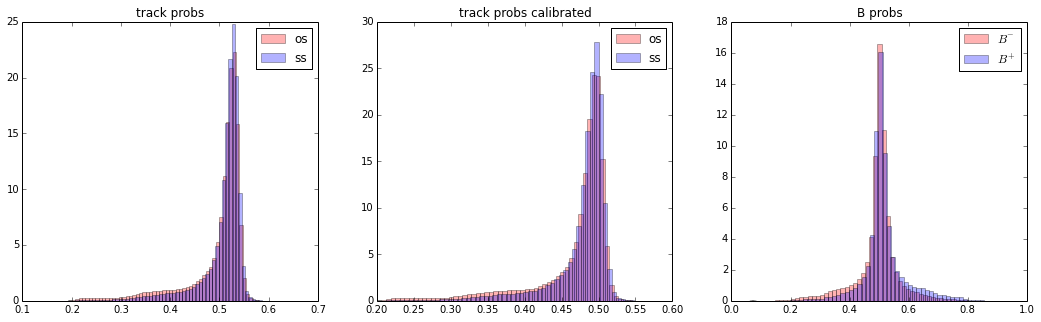

AUC for tagged: 0.589043521305 AUC with untag: 0.563854466862


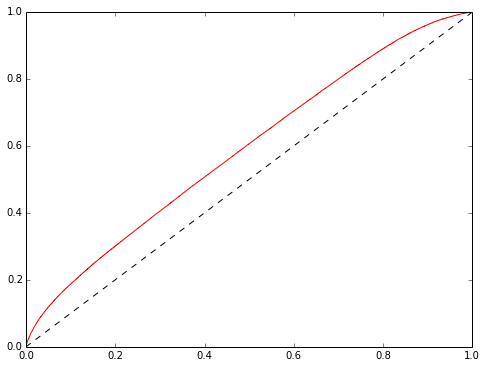

KFold prediction using folds column
KFold prediction using folds column

In [ ]:
D2_step = []
tagging_efficiency_step = []
tagging_efficiency_delta_step = []
auc_step = []

for step, random_state in zip(range(len(random_states)), random_states):
    tagging_efficiency, tagging_efficiency_delta, D2, auc = tagging(tt_base, mn_base, track_logistic=True,
                                                                    vertex_logistic=False,
                                                                    random_state=random_state)
    D2_step.append(D2)
    tagging_efficiency_step.append(tagging_efficiency)
    tagging_efficiency_delta_step.append(tagging_efficiency_delta)
    auc_step.append(auc)

KFold prediction using folds column
KFold prediction using folds column


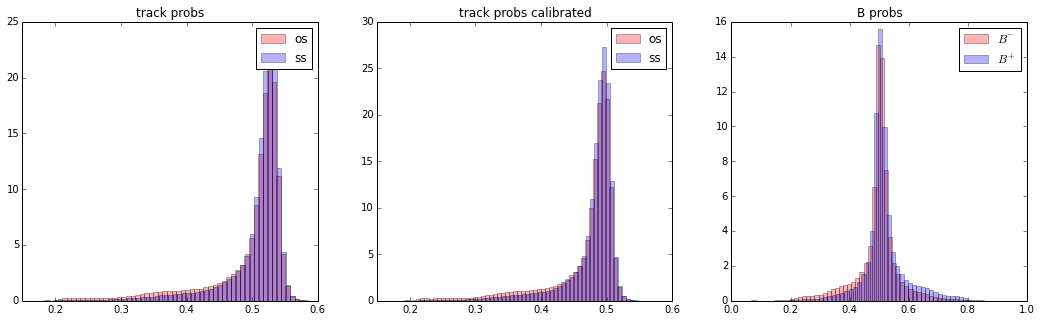

AUC for tagged: 0.588327111386 AUC with untag: 0.563209413424


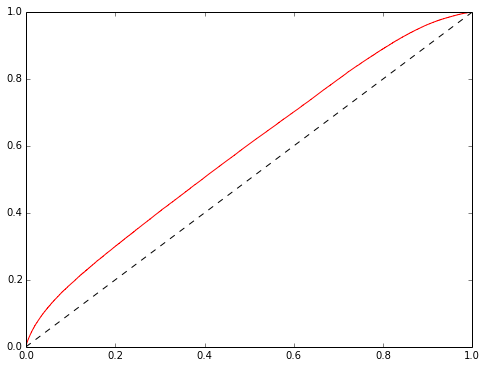

KFold prediction using folds column
KFold prediction using folds column


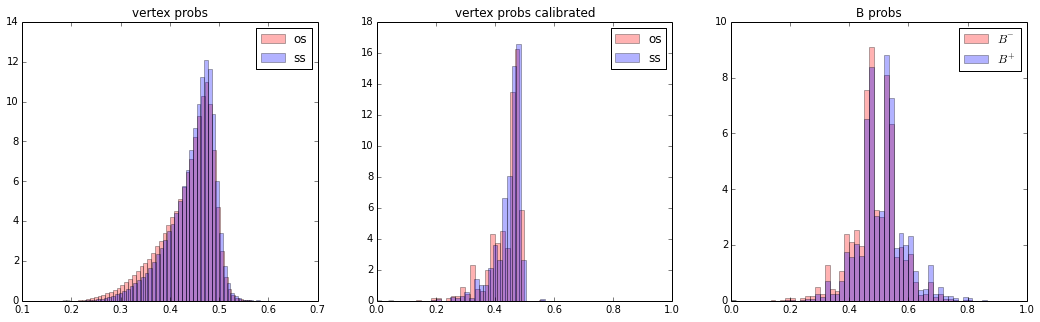

AUC for tagged: 0.594471010235 AUC with untag: 0.546610247664


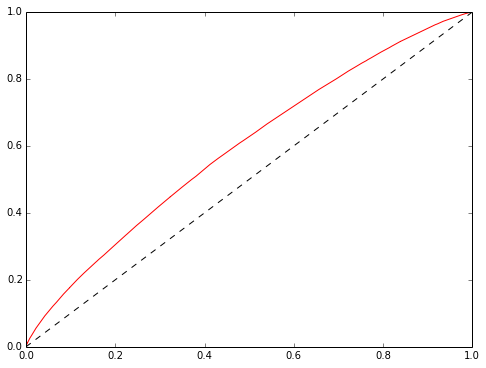

AUC for tagged: 0.59612798189 AUC with untag: 0.579190649821
KFold prediction using folds column
KFold prediction using folds column


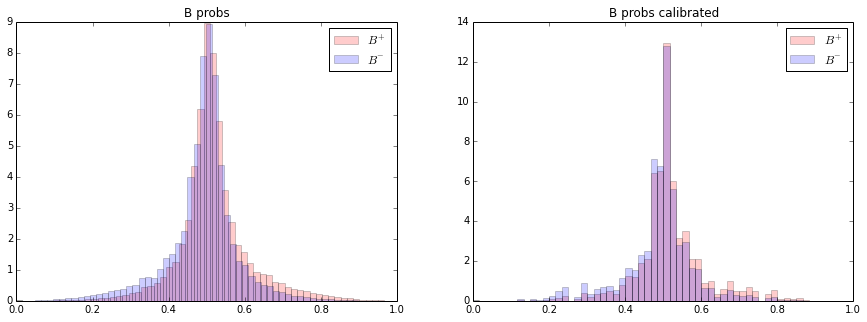

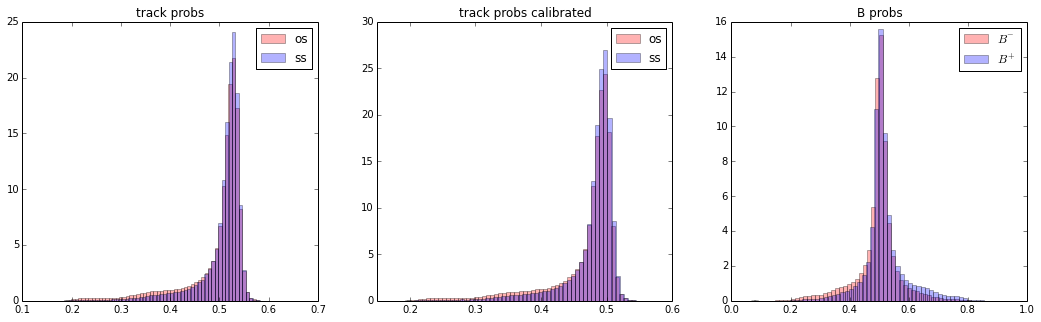

AUC for tagged: 0.588031758614 AUC with untag: 0.563023312213


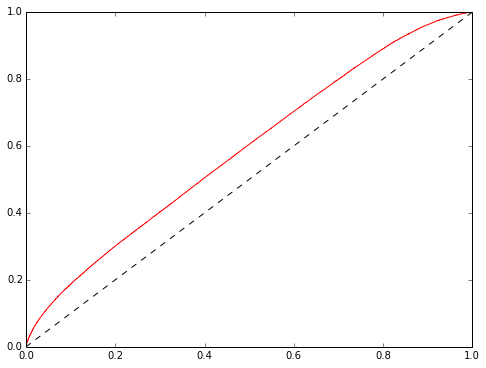

KFold prediction using folds column
KFold prediction using folds column


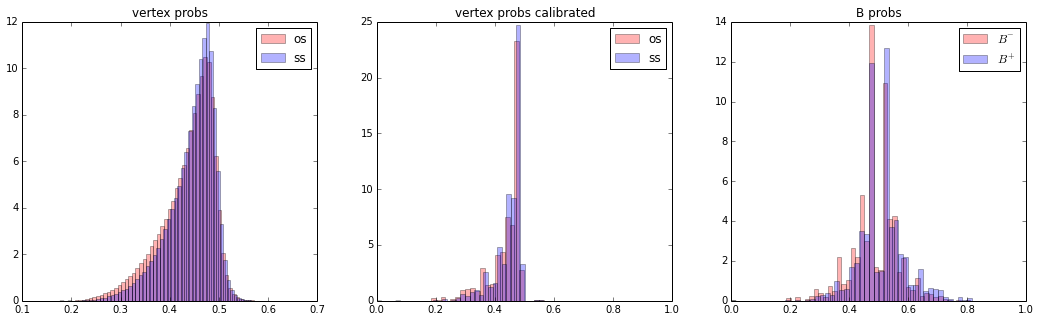

AUC for tagged: 0.594633725279 AUC with untag: 0.546755110488


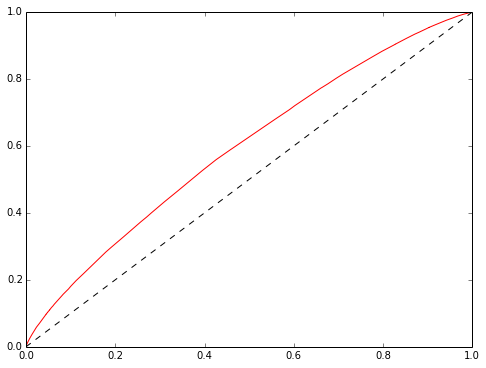

AUC for tagged: 0.596340486637 AUC with untag: 0.579667831915
KFold prediction using folds column
KFold prediction using folds column


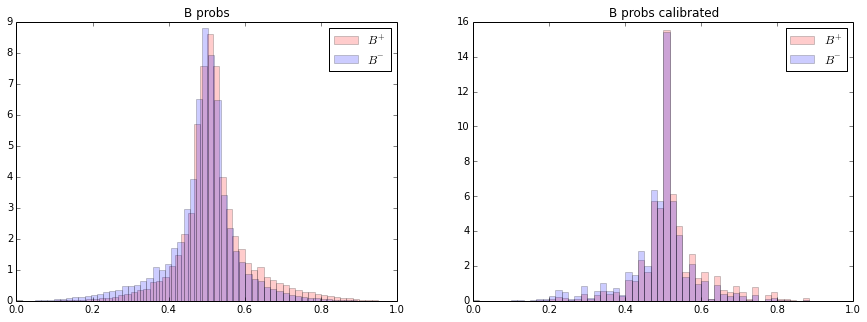

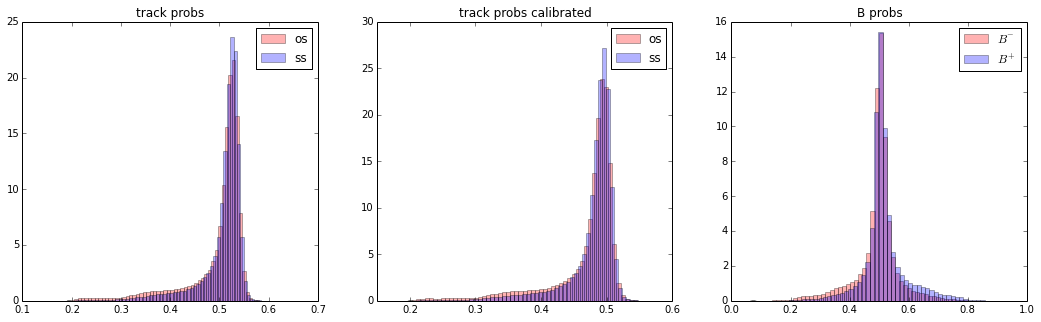

AUC for tagged: 0.588275695655 AUC with untag: 0.563095192463


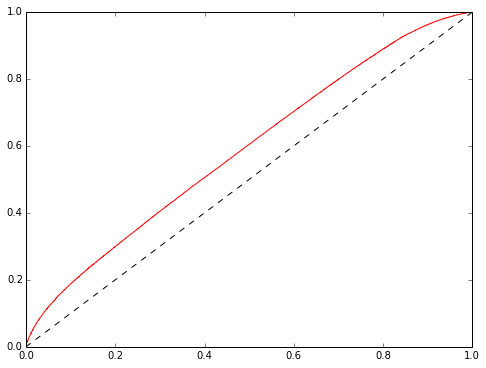

KFold prediction using folds column
KFold prediction using folds column


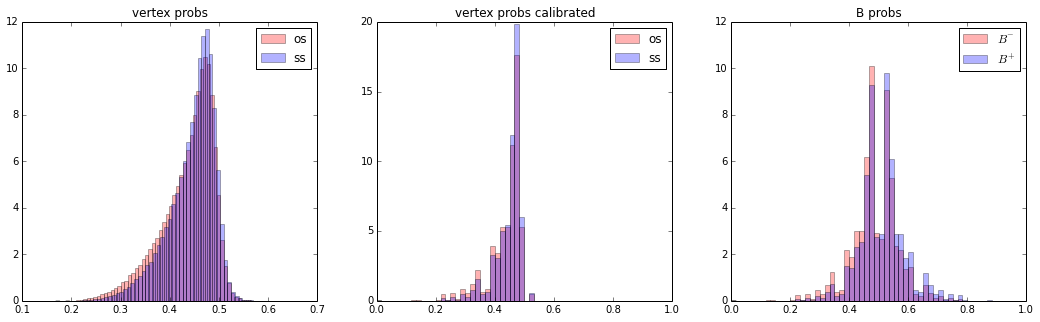

AUC for tagged: 0.594186209361 AUC with untag: 0.54648104842


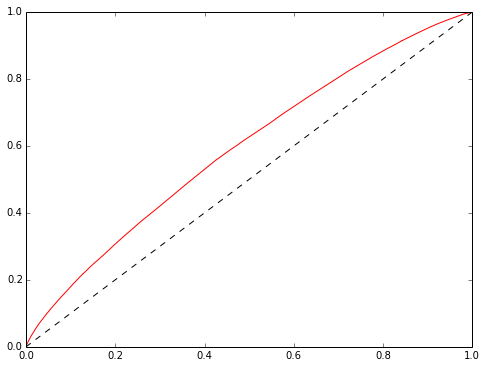

AUC for tagged: 0.596284091067 AUC with untag: 0.579614532364
KFold prediction using folds column
KFold prediction using folds column


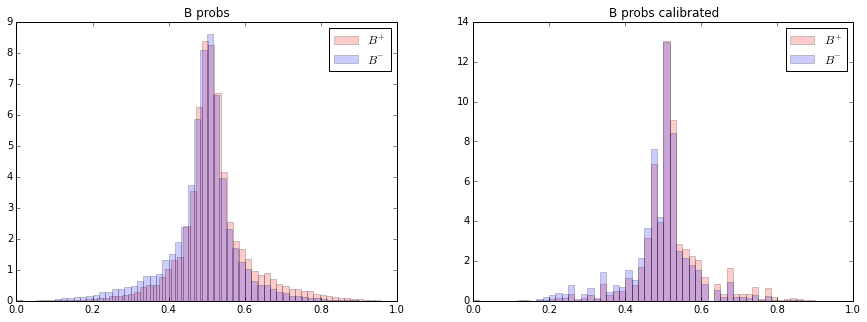

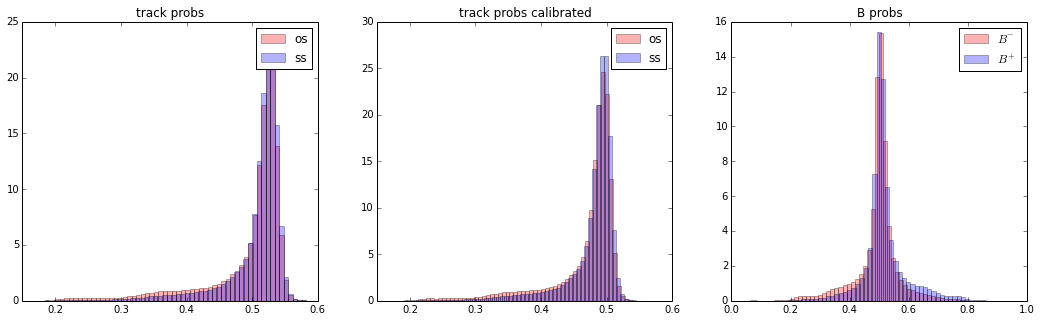

AUC for tagged: 0.588385221348 AUC with untag: 0.563371198477


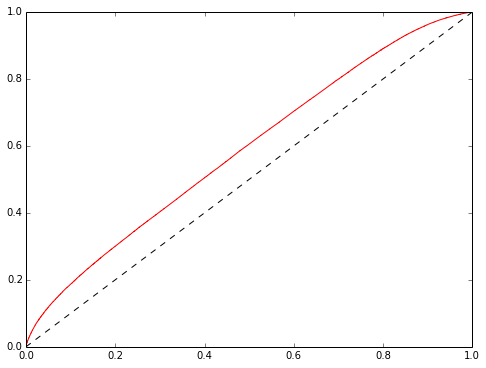

KFold prediction using folds column
KFold prediction using folds column


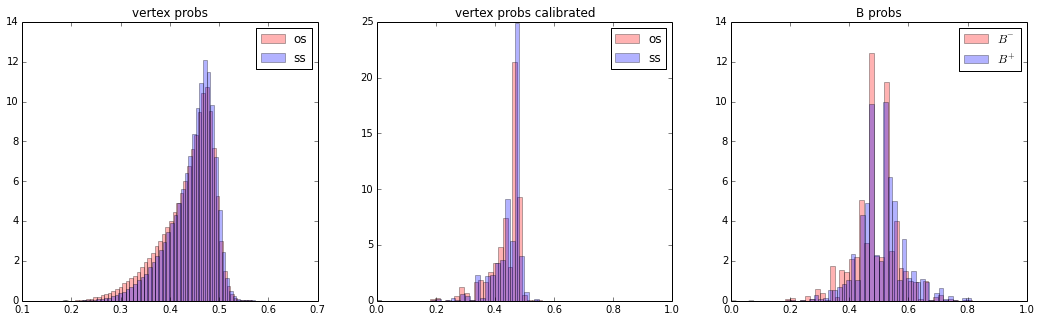

AUC for tagged: 0.594417739277 AUC with untag: 0.546550695091


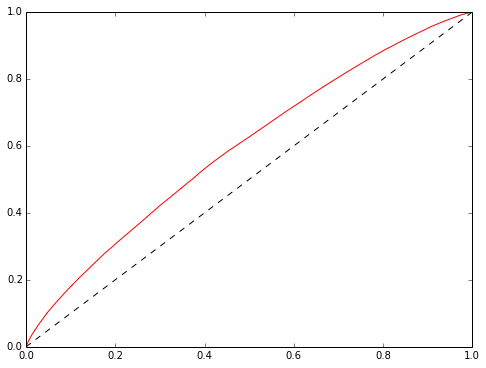

AUC for tagged: 0.596668600365 AUC with untag: 0.579882535728
KFold prediction using folds column
KFold prediction using folds column


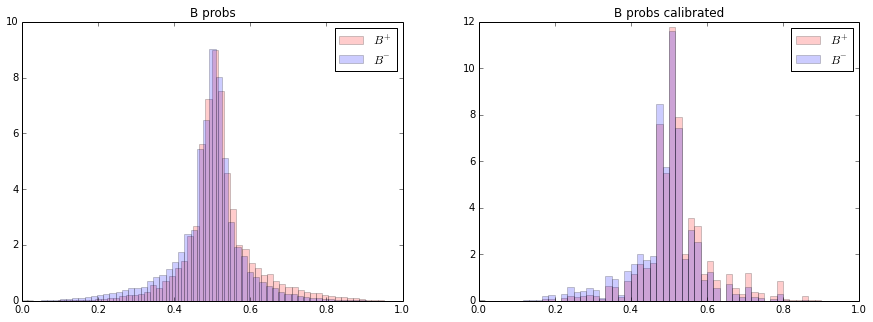

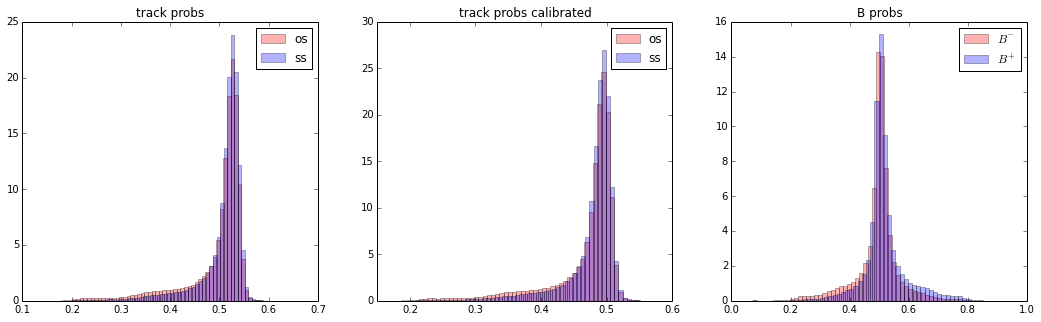

AUC for tagged: 0.587769071018 AUC with untag: 0.562823341638


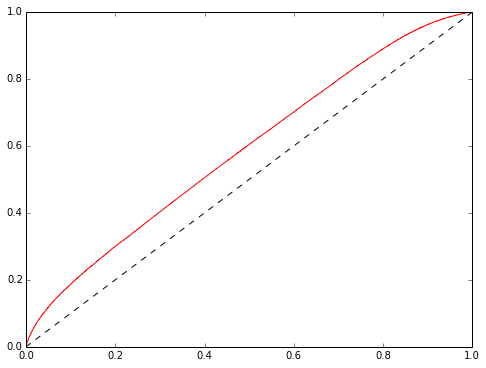

KFold prediction using folds column
KFold prediction using folds column


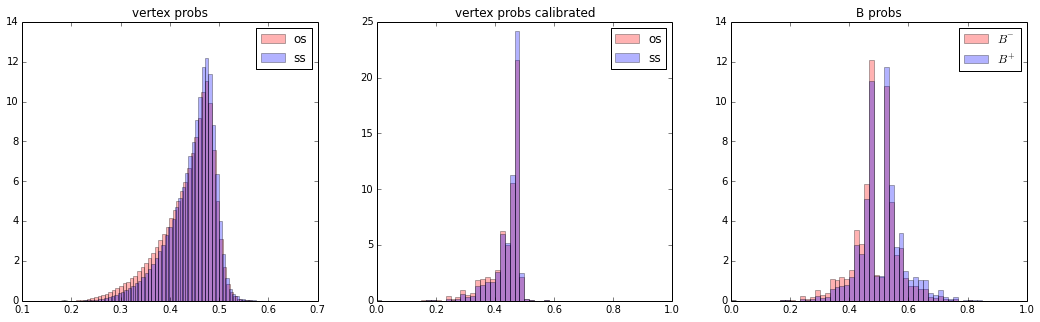

AUC for tagged: 0.594118555706 AUC with untag: 0.546630034224


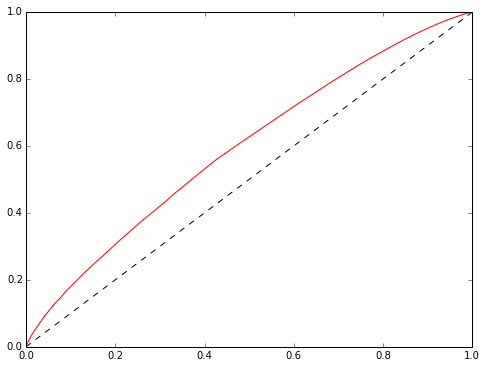

AUC for tagged: 0.595994195561 AUC with untag: 0.5790444874
KFold prediction using folds column
KFold prediction using folds column


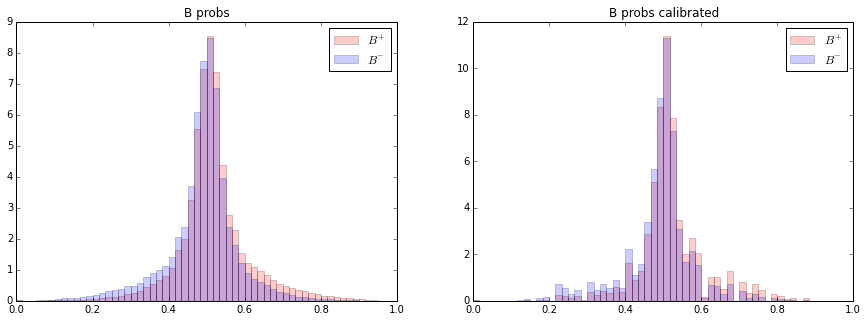

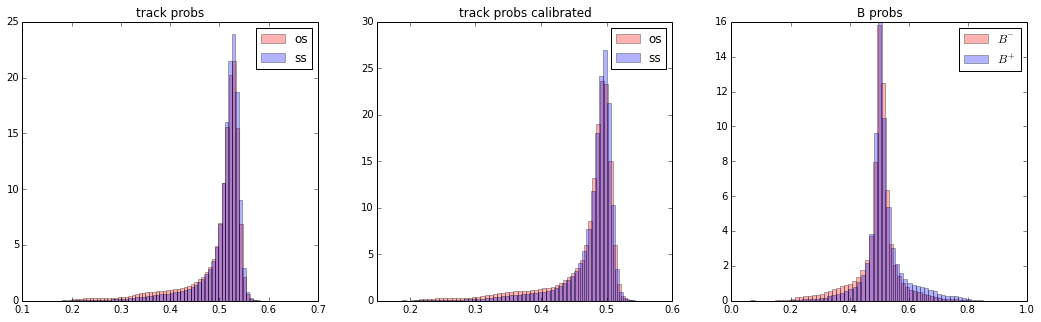

AUC for tagged: 0.588331688563 AUC with untag: 0.563295895486


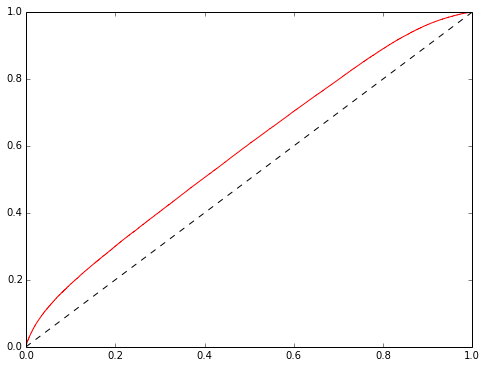

KFold prediction using folds column
KFold prediction using folds column


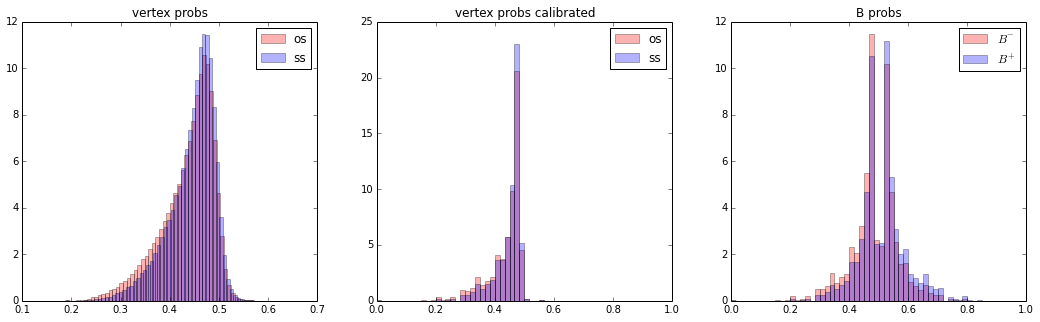

AUC for tagged: 0.594139861203 AUC with untag: 0.546629271042


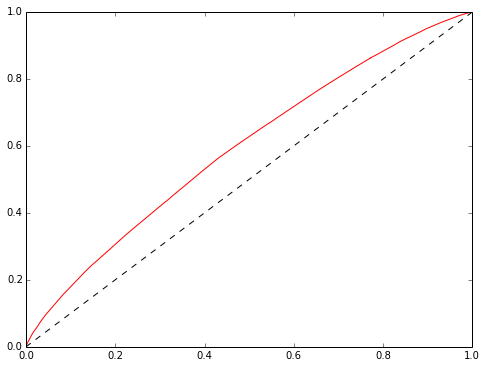

AUC for tagged: 0.596391180731 AUC with untag: 0.579615344002
KFold prediction using folds column
KFold prediction using folds column


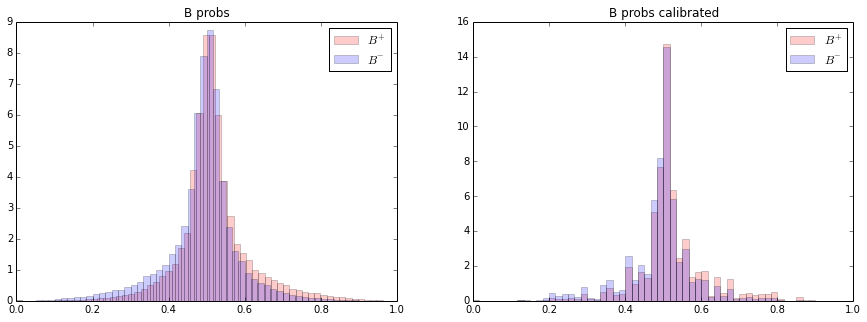

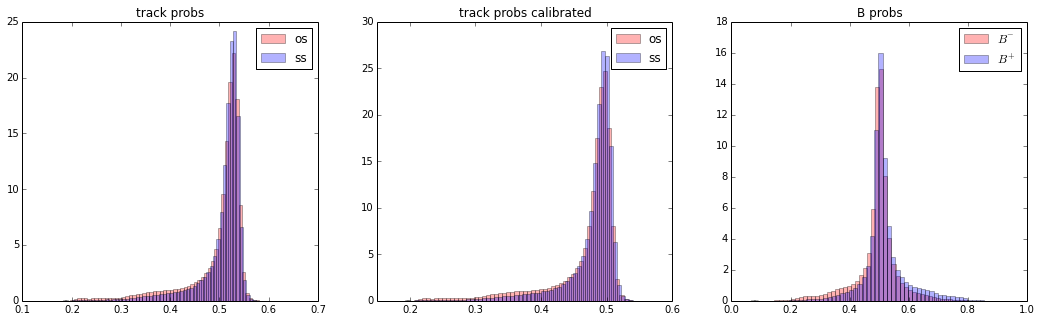

AUC for tagged: 0.588497797466 AUC with untag: 0.563234905887


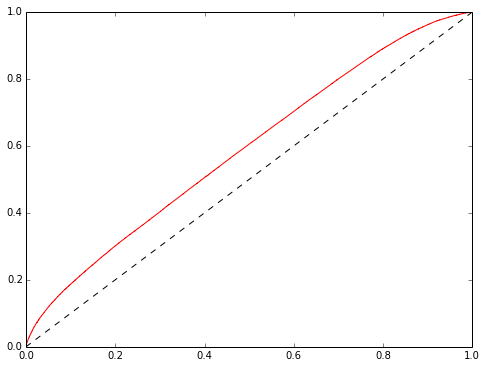

KFold prediction using folds column
KFold prediction using folds column


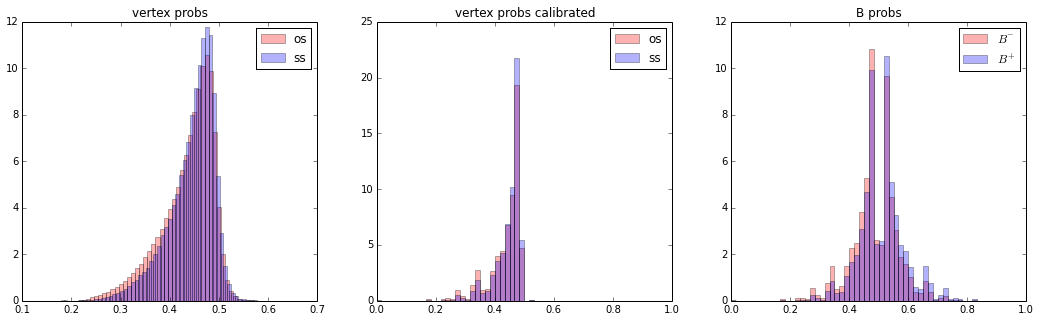

AUC for tagged: 0.594960037567 AUC with untag: 0.546746418761


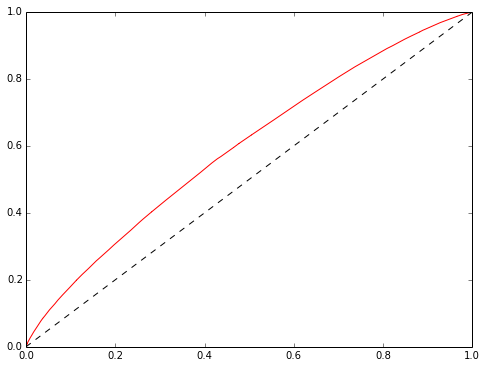

AUC for tagged: 0.59646558871 AUC with untag: 0.579554852448
KFold prediction using folds column
KFold prediction using folds column


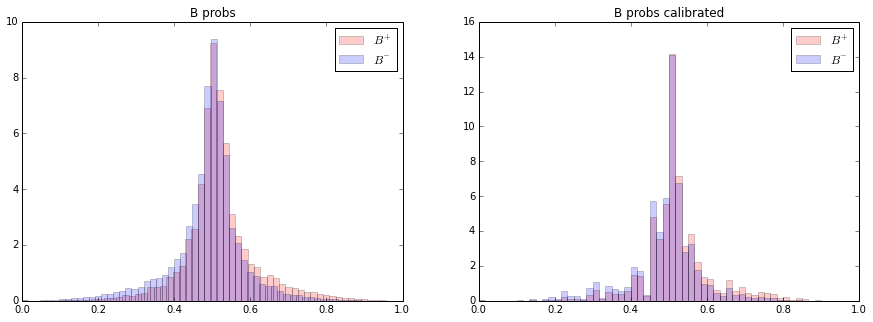

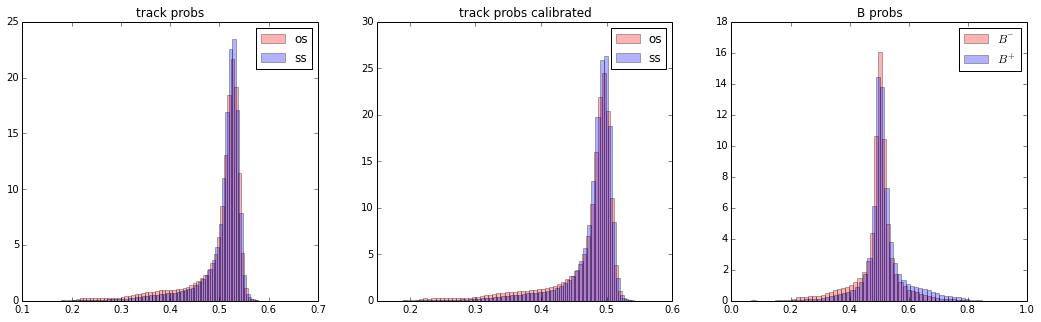

AUC for tagged: 0.588298031688 AUC with untag: 0.563206633711


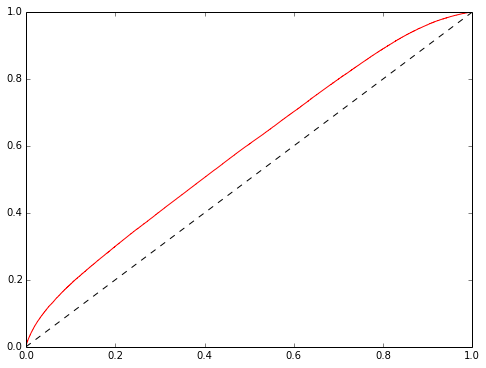

KFold prediction using folds column
KFold prediction using folds column


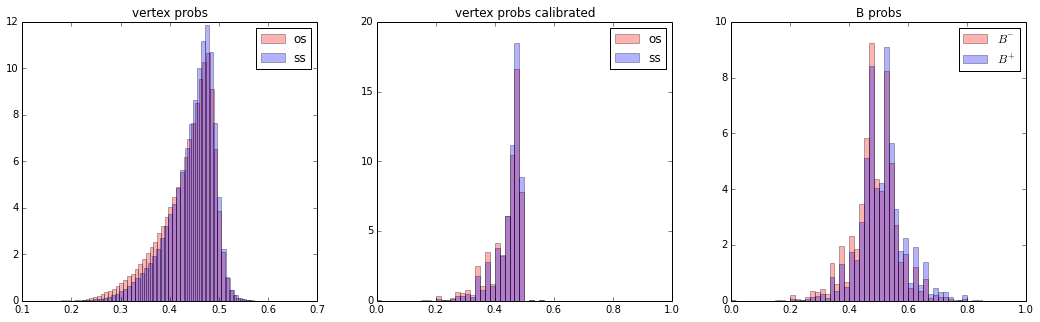

AUC for tagged: 0.593864069291 AUC with untag: 0.546530551802


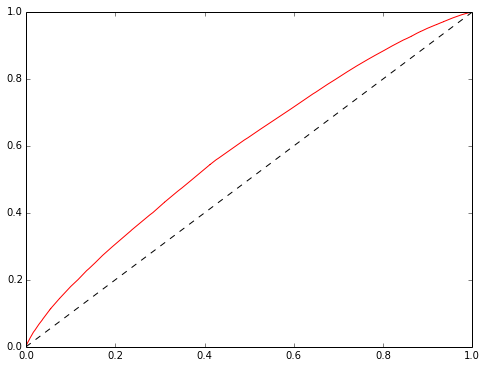

AUC for tagged: 0.596186867141 AUC with untag: 0.579288313182
KFold prediction using folds column
KFold prediction using folds column


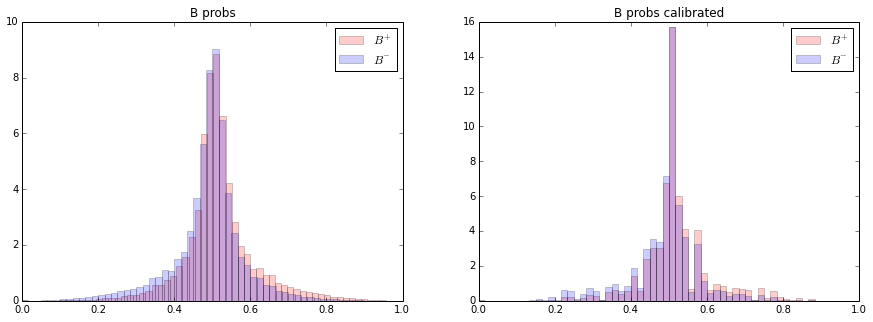

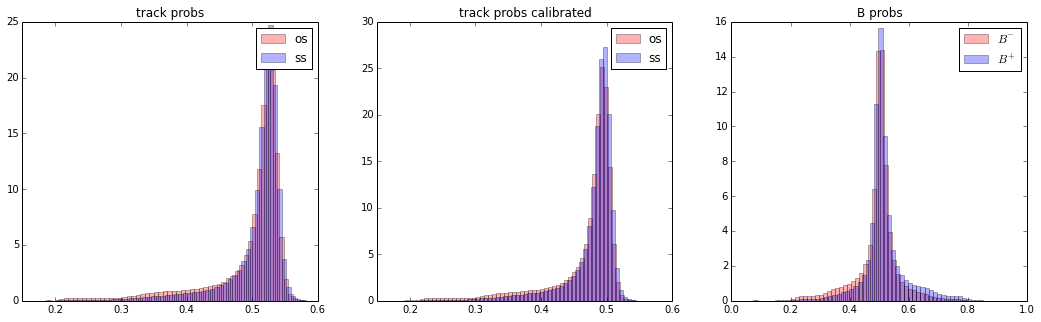

AUC for tagged: 0.588584593334 AUC with untag: 0.56358339954


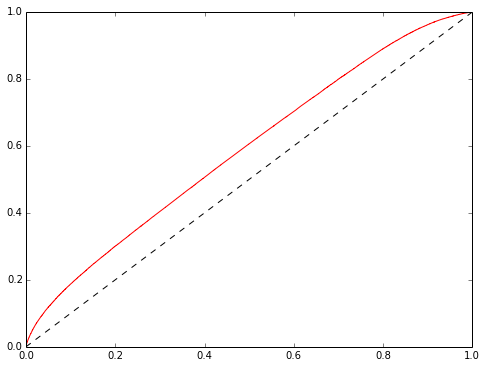

KFold prediction using folds column
KFold prediction using folds column


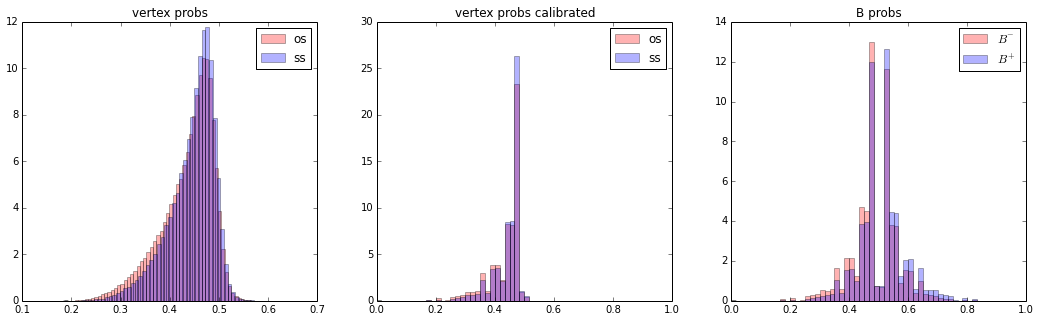

AUC for tagged: 0.594494731232 AUC with untag: 0.546547787154


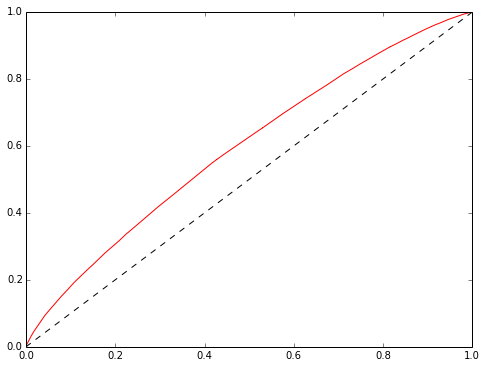

AUC for tagged: 0.596466422069 AUC with untag: 0.57962835439
KFold prediction using folds column
KFold prediction using folds column


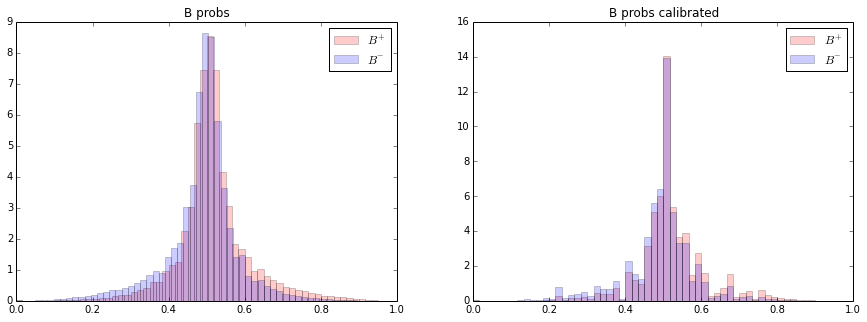

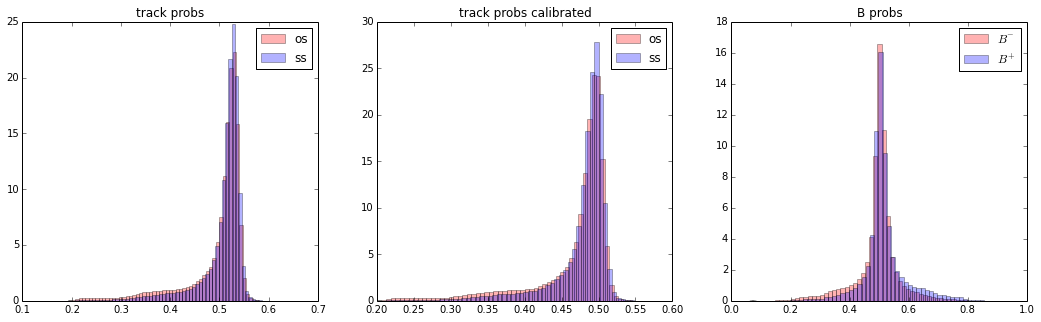

AUC for tagged: 0.589043521305 AUC with untag: 0.563854466862


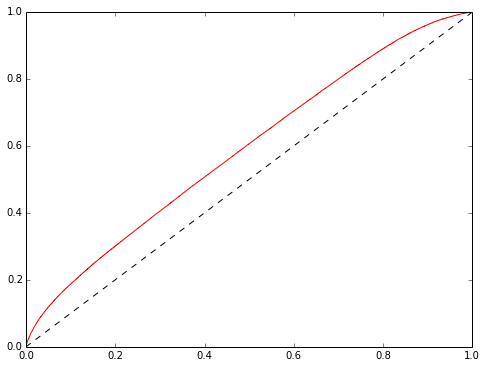

KFold prediction using folds column
KFold prediction using folds column


AttributeError: max must be larger than min in range parameter.

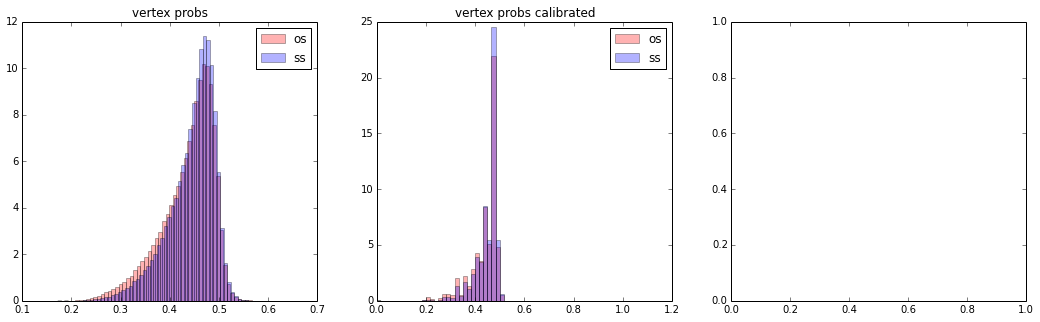

# Result quality with full systematic error

In [30]:
from utils import result_table

In [31]:
result = result_table(numpy.mean(tagging_efficiency_step), numpy.mean(tagging_efficiency_delta_step),
                      D2_step, auc_step, name='NEW + full systematic')
result

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,NEW + full systematic,77.789955,0.102331,0.034897,0.000083,2.714597,0.007391,57.949854,0.025131


In [32]:
result = result_table(numpy.mean(tagging_efficiency_step), numpy.mean(tagging_efficiency_delta_step),
                      D2_step, auc_step, name='NEW + full systematic')
result.to_csv('img/new-tagging-systematic.csv', header=True, index=False)